# Image Analysis I (2023)
## Lab 1: Hand-crafted features & Bayesian classifiers

Please enter your group number and the data from all group members below (double click to edit the table).

| Group __03__ | Name  | Matr.-nr. |
|-|-|-|
|   Member 1  | Chengliang Li | 10043349 |
|   Member 2  | Tingde Liu | 10050301 |
|   Member 3  | Yahui Zhang | 10050017 |

In this lab, first you will implement methods to extract features from images, implement and train Bayesian classifiers to classify real images using the extracted features. After that, you will apply the classifiers to a synthetic toy dataset in a 2D feature space.

The __libraries__ required for this lab can be installed by running the following command in a code cell:

``!conda install numpy matplotlib scikit-learn imageio``

__Note that this only needs to be done if you have not installed these libraries already.__

Required __imports__ for this lab. Do not forget to run the following cell (which may __take up to some minutes__ because some functions are compiled).

In [1]:
# IMPORTS
import lab                                      # Given functions
import numpy as np                              # Numerical computations
import matplotlib                               # Plots
import matplotlib.pyplot as plt     
import imageio.v2 as imageio
import tifffile   


# GLOBAL SETTINGS
PlotSize = 8                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = plt.cm.Accent                             # Color mapping 
np.set_printoptions(precision=3)                 # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names   = ['STREET','HOUSE','LOW VEG.','HIGH VEG.','CAR']
feature_names = ['NDVI','NDSM','NIR','RED','GREEN']
num_classes   = len(class_names); num_features = len(feature_names)

training_set_path = './Data/Vaihingen/Train/'     # Relative path to training patch root folder
test_set_path     = './Data/Vaihingen/Test/'      # Relative path to test patch root folder

## Exercise 1: Feature extraction & Data preparation

### Exercise 1.1: Normalized Difference Vegetation Index (NDVI)
__Implement__ the function below, which computes a NDVI image. You can assume that the first channel of the input image corresponds to the near infrared band ($NIR$) and the second channel corresponds to the red band ($R$). The $NDVI$ is defined as

$$ NDVI = \dfrac{NIR-R}{NIR+R} $$

In [2]:
def compute_ndvi(I):
    h, w, d = I.shape
    assert d == 3, "ndvi computation only valid on multi channel images!"
    num_samples = h*w

    # YOUR CODE GOES HERE
    

    NIR = I[:,:,0]   # first channel of image
    R   = I[:,:,1]     # second channel of image
    NIR_R = NIR + R
    NIR_R = np.where(NIR_R==0, np.inf, NIR_R)   # if NIR + R =0, let this value equal to infinity, so (1 / infinity) equal to 0
    NDVI = (NIR - R)/ NIR_R

    return NDVI

    #
    # Step 1: compute the NDVI channel from the first and second channels of Image
    # step 2: prevent a possible division by zero
    


__Run__ the next cell to test your implementation.

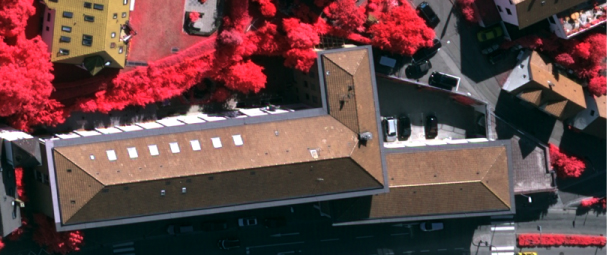

Original Image


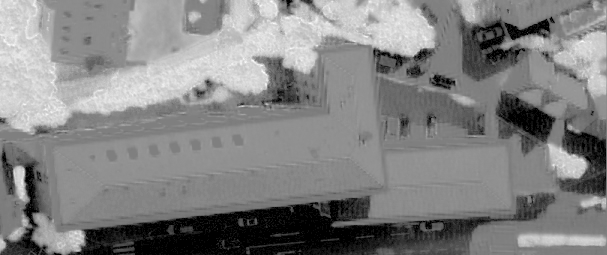

Normalized Difference Vegetation Index (normalized)


In [3]:
I = lab.imread3D('images/houseigb.jpg')

# apply your function on the Image
NDVI = compute_ndvi(I)

# compute normalized NDVI-image
NDVI = lab.normalize(NDVI.reshape((I.shape[0], I.shape[1], 1)))

lab.imshow3D(I)
print('Original Image')

lab.imshow3D(NDVI)           
print('Normalized Difference Vegetation Index (normalized)')

### Exercise 1.2: Data pre-processing

#### Data overview

In this exercise aerial images will be classified. There is one patch for training and one for testing. Each patch has a size of $800px \times 800 px$. For each pixel the values for

- Near infra red (NIR)
- Red (R)
- Green (G)

are available in the image ('IR_R_G.png'), where the first channel corresponds to NIR, the second to Red and the third to Green. The values are quantized with 8 bits (1 byte) per pixel and channel. Additionally, a normalized digital surface model (NDSM) is available. The information is stored in an image having 32 bits per pixel ('NDSM.tif'), each pixel containing the height above ground in [m] as a `float32` value. The ground truth (GT) labels are given in a colour coded image file ('GT.png'), in which colours correspond to class labels. 

__Run__ the next two cells to visualize the data.

Training data


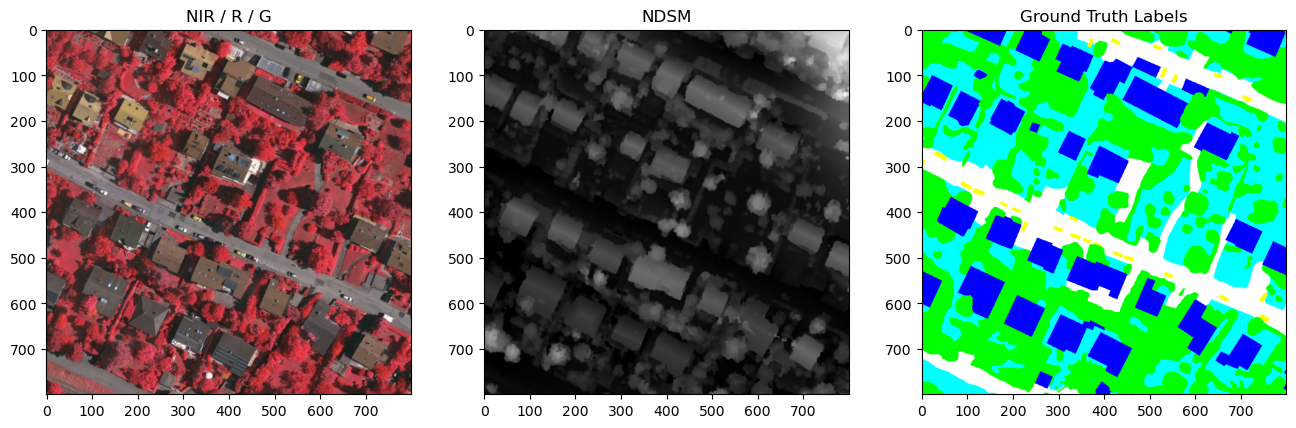

In [4]:
print('Training data')
lab.plot_patch(training_set_path)

Test data


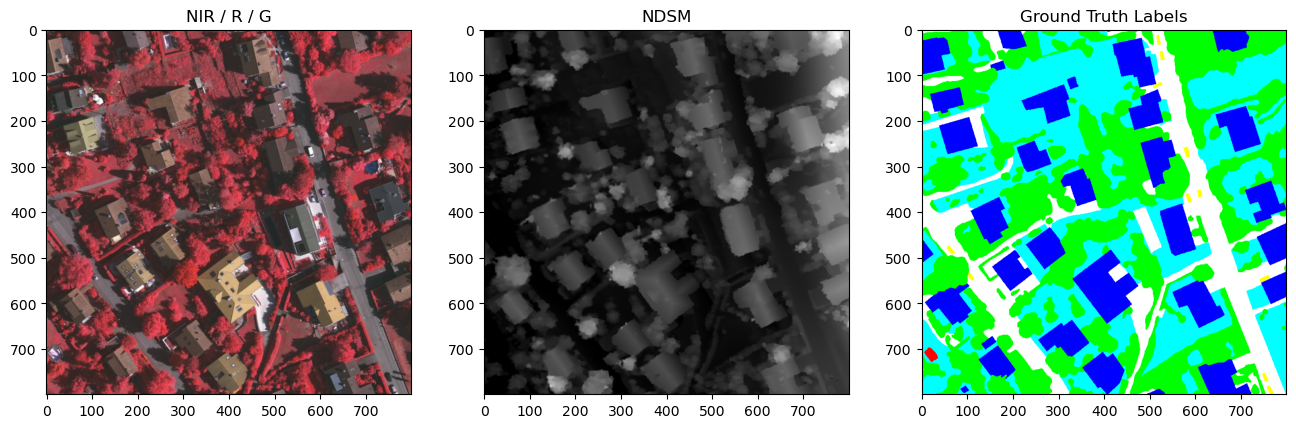

In [5]:
print('Test data')
lab.plot_patch(test_set_path)

__Implement__ the function `read_patch(root_folder)`. The function should:

- Read IR_R_G, NDSM and GT images located inside the `root_folder`, using the filenames given above
- Change data type of IR, R and G to `float32`
- Compute the NDVI as an additional feature (call the function you implemented in Exercise 1.1)
- Shift and scale IR, R and G so that 0 will be mapped to -1.0 and 255 will be mapped to 1.0 
- Normalize the NDSM by subtracting 5.0 before dividing by 5.0.
- Build the GT label maps using the given color codes. __The classes clutter and low vegetation should be merged!__

The function should return two arrays $X, y$, where $X$ is an $N\times 5$ matrix and $y$ is an $N$-dimensional vector holding the true labels. $N$ is the number of samples ($N_{rows}\times N_{cols}$, i.e. the number of rows times the number columns of the images; here, we have $N_{rows} = N_{cols} = 800$). Each row in $X$ should contain the normalized features in the order (NIR, R, G, NDSM, NDVI).

__Colour codes of the classes:__

|Class ID|Description|Colour|Value|
|-|-|-|-|
|0|Street|WHITE|(255,255,255)|
|1|Building|BLUE|(0,0,255)|
|2|Low Vegetation|CYAN|(0,255,255)|
|3|High Vegetation|GREEN|(0,255,0)|
|4|Car|YELLOW|(255,255,0)|
|__2__|Clutter|RED|(255,0,0)|

In [6]:
def read_patch(root_folder):
    
    # Read images
    # Convert IR,R,G to float32
    # Compute NDVI: call compute_ndvi(); your previous implementation
    # Shift and scale 'IRRG' 
    # Shift and scale NDSM by using the instructions given in the above description
    # Stack features to 'X'
    # Save labels to 'y'

    IR_R_G = np.array(imageio.imread(root_folder + 'IR_R_G.png').astype(np.float32))
    NDSM   = np.array(imageio.imread(root_folder + 'NDSM.tif'))
    GT     = np.array(imageio.imread(root_folder + 'GT.png'))

    NDVI = compute_ndvi(IR_R_G)
    NDVI_norm = np.asarray(lab.normalize(NDVI).astype(np.uint8))

    IR_R_G_norm = (IR_R_G / 127.5) - 1

    NDSM = (NDSM - 5.0) / 5.0
    NDSM_norm = np.asarray(lab.normalize(NDSM).astype(np.uint8))

    color_to_class = {(255,255,255): 0,
                      (  0, 0 ,255): 1,
                      (  0,255,255): 2,
                      (  0,255,  0): 3,
                      (255,255,  0): 4,
                      (255,  0,  0): 2}
    
    GT_label = np.zeros((GT.shape[0], GT.shape[1]))
    for i in range(GT.shape[0]):
        for j in range(GT.shape[1]):
            color = (GT[i][j][0], GT[i][j][1], GT[i][j][2])
            if color in color_to_class:
                GT_label[i, j] = color_to_class[color]

    X = np.hstack(([IR_R_G_norm[:,:,0].reshape(-1,1), IR_R_G_norm[:,:,1].reshape(-1,1),IR_R_G_norm[:,:,2].reshape(-1,1), NDSM_norm.reshape(-1,1), NDVI_norm.reshape(-1,1)]))
    y = np.array(GT_label).reshape((-1,)).astype(np.uint8)
    
    return X, y

__Run__ the next cell to read the training and testing patch. The assertions will check the shape of the result.

In [7]:
X, y = read_patch(training_set_path)
X_t, y_t = read_patch(test_set_path)

assert X.shape == (800*800, 5), "X has a wrong shape"
assert y.shape == (800*800,),   "y has a wrong shape"

print('min/max irrg', np.min(X_t[:,:3]), np.max(X_t[:,:3]))
print('min/max ndsm', np.min(X_t[:, 3]), np.max(X_t[:, 3]))
print('min/max ndvi', np.min(X_t[:, 4]), np.max(X_t[:, 4]))

min/max irrg -0.77254903 0.99215686
min/max ndsm 0.0 255.0
min/max ndvi 0.0 255.0


### Feature selection

In the next cell, use your previous implementation of the function `read_patch()` to select only two features: __NDSM__ and __NDVI__. The `_t` used in variables defined below stands for test samples.

In [8]:
X, y     = read_patch(training_set_path) # training
X_t, y_t = read_patch(test_set_path)     # testing
 
# YOUR CODE GOES HERE!


ndsm, ndsm_t, ndvi, ndvi_t = X[:,3].reshape(-1,1), X_t[:,3].reshape(-1,1), X[:,4].reshape(-1,1), X_t[:,4].reshape(-1,1)

# # New training and test sample sets
X   = np.hstack((ndsm, ndvi))
X_t = np.hstack((ndsm_t, ndvi_t))
#print(ndsm)
# The assertions will again check the shape of the result.
assert X.shape == (800*800, 2), "X has a wrong shape"
assert y.shape == (800*800,),   "y has a wrong shape"

## Exercise 2: Evaluation

For a visual evaluation __implement__ the function `get_labels_as_image()` that turns a label vector $Y$ back into an image with height, width and depth as defined in `shape`. 

In [9]:
def get_labels_as_image(Y, shape):
    # Convert labels Y back to a color image
    im = np.zeros((shape[0],shape[1],3), dtype = int)
    Y=Y.reshape(800,800)
    class_to_color = {  0:(255,255,255),
                        1:(0,0,255),
                        2:(0,255,255),
                        3:(0,255,0),
                        4:(255,255,0),             
                  }
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                if Y[i][j] in class_to_color:
                    im[i][j][k] = class_to_color[Y[i][j]][k]

    return im

The code in the next cell will check your implementation.

In [10]:
YC = np.sum(imageio.imread(training_set_path + 'GT.png')*(1,3,5),-1)
YP = np.sum(get_labels_as_image(y, [800,800,3])*(1,3,5),-1)
if np.equal(YC[YC>255], YP[YC>255]).all():
    print('implementation seems correct!')
else:
    print('implementation seems wrong!')

implementation seems correct!


To analyze the classifiers quantitatively, we need a function that computes quality metrics. 
__Implement__ the function below, that computes the following metrics (all in range 0 - 1):

- Precision per class (1D array)
- Recall per class (1D array)
- F1-score per class (1D array)
- Overall accuracy (scalar)
- Mean F1-score  (scalar)

The function takes the array of predictions $Y$, the corresponding reference labels $y$ and the number of classes $C$ as input.

In [11]:
def compute_quality_metrics(Y, y, C):
    # YOUR CODE GOES HERE
    
    Matrix = np.zeros((C,C))
    for i in range(len(Y)):
        if Y[i] == y[i]:
            Matrix[Y[i],Y[i]] += 1
        else:
            Matrix[Y[i],y[i]] += 1
            
    precisions = Matrix.diagonal() / np.sum(Matrix, axis=1)
    recalls =  Matrix.diagonal() / np.sum(Matrix, axis=0)
    f1_scores = 2/(1/precisions + 1/recalls)
    
    overall_accuracy = np.sum(Matrix.diagonal()) / len(Y)
    mean_f1_score = np.sum(f1_scores) / C
    
    return precisions, recalls, f1_scores, overall_accuracy, mean_f1_score

## Exercise 3: Generative probabilistic classifiers
### Exercise 3.1: Single Gaussian Model
In the following cell, some code for a Bayesian classifier using a single Gaussian Model for the likelihood (Normal Distribution Classifier, NDC) is given. The class design is adapted from the module scikit-learn. Following that implementation each classifier is implemented as a class. The method `fit(X, y)` takes the training samples $X$ and the corresponding labels $y$ as arguments and fits the model to the data. For the NDC this means to compute the mean and covariance for each class. The function `compute_likelihoods(X)` computes the likelihoods for the given feature vectors $X$ to belong to each of the classes.

__Complete__ the method ``fit(X, y)`` that computes the mean and the covariance matrix for each class.

__Complete__ the method ``compute_likelihoods(X)`` that computes the likelihood of the features `X`.

__Complete__ the method ``compute_posteriors(L, P_prior)`` that computes the posterior probabilities $P_{post}$ for $N$ samples. Inputs are the likelihood tensor $L$ with shape $N\times c$ for $N$ samples and $c$ classes and the prior probabilities $P_{prior}$ for the classes. Remember, $P_{prior}$ is a one dimensional vector that contains the prior probabilities for each class: $P_{prior} = [p(C_0), ... ,p(C_c)]$. Make sure, not to modify $L$ in this function.

In [12]:
from scipy.stats import multivariate_normal
class NormalDistributionClassifier():
    
    def __init__(self, num_classes, num_features):
        #  Initializes the classifier
        #  num_classes: number of classes
        #  num_features: number of features (length of each feature vector)
        
        C = num_classes
        F = num_features
        self.num_classes = C                    # Store number of classes  
        self.num_features = F                   # Store number of features 
        self.means = np.zeros((C, F))           # Init means
        self.covars = np.zeros((C, F, F))       # Init covars
        self.inv_covars = np.zeros((C, F, F))   # Init inverses of covars
        self.det_covars = np.zeros((C))         # Init determinants
    
    
    def fit(self, X, y):
        #  Computes mean and covariance matrix for each class using ML
        #  X: feature_vectors [num_feature_vectors x num_features]
        #  y: corresponding labels [num_feature_vectors]
        
        feature_vectors_by_classes = lab.get_feature_vectors_by_classes(X, y) # Group samples by classes
        for c in range(self.num_classes):
            feature_vecs_class_c = feature_vectors_by_classes[c]
            ########################################################## 
            
            # YOUR CODE GOES HERE!
            
            self.means[c] = np.mean(feature_vecs_class_c, axis=0) # mean for class c
            self.covars[c] = np.cov(feature_vecs_class_c.T)# covariance matrix for class c
            
            ###########################################################
            
            self.inv_covars[c] = np.linalg.pinv(self.covars[c])
            self.det_covars[c] = np.linalg.det(self.covars[c])

    def uniform_prior(self):
        # Assumes uniform priors
        
        return [1/self.num_classes for i in range(self.num_classes)] 
        #returns a list of probabilities where each class has a probability of 1/self.num_classes.
            
    def compute_likelihoods(self, X):
        #  Computes likelihoods for feature vectors
        #  X: feature_vectors [num_feature_vectors x num_features]
        
        num_samples = X.shape[0]                                  # Number of samples to predict
        likelihoods = np.zeros((num_samples, self.num_classes))   # Init. likelihood matrix
        
        for xi, x in enumerate(X):#enumerate(X)listing both the data x and the data subscript xi
            for c in range(self.num_classes):
                ########################################################## 
                
                # YOUR CODE GOES HERE!
            
                likelihoods[xi, c] = multivariate_normal.pdf(x,mean=self.means[c], cov=self.covars[c])
                #multivariate_normal()A multivariate normal random variable.
                ##########################################################
                
        return likelihoods

    
    def compute_posteriors(self, L, P_prior=None):
        # Computes posteriors for feature vectors
        #  X: feature_vectors [num_feature_vectors x num_features]
        
        # If the P_prior is None, we assume a uniform prior.This will help us
        # to call the function .predict() without specifiying priors beforehand.
        if P_prior is None:
            P_prior = self.uniform_prior()
        assert np.sum(P_prior) == 1.0, "The prior has to sum up to one!"
        ##########################################################
        
        # YOUR CODE GOES HERE!
        
        #First we multiply the prior by likehoood and then normalize it.
        posteriors = (L * P_prior) / np.dot(L,np.asarray(P_prior).reshape(-1,1)) 
   
        
        ##########################################################
        return posteriors
    
    def predict(self, X):
        
        # Predicts labels for feature vectors in X
        #  X: feature_vectors [num_feature_vectors x num_features]
        
        P = self.compute_posteriors(self.compute_likelihoods(X))
        return np.argmax(P, axis=1)

In the next cell a classifier is created and trained. __Run the cell__ to check your implementation.

In [13]:
# Create classifier instance
ndc = NormalDistributionClassifier(num_classes=num_classes, num_features=2)

# Train the classifier
ndc.fit(X, y)

The next two cells will compute the predictions by assuming a uniform prior and run the qualitative and visual evaluation.

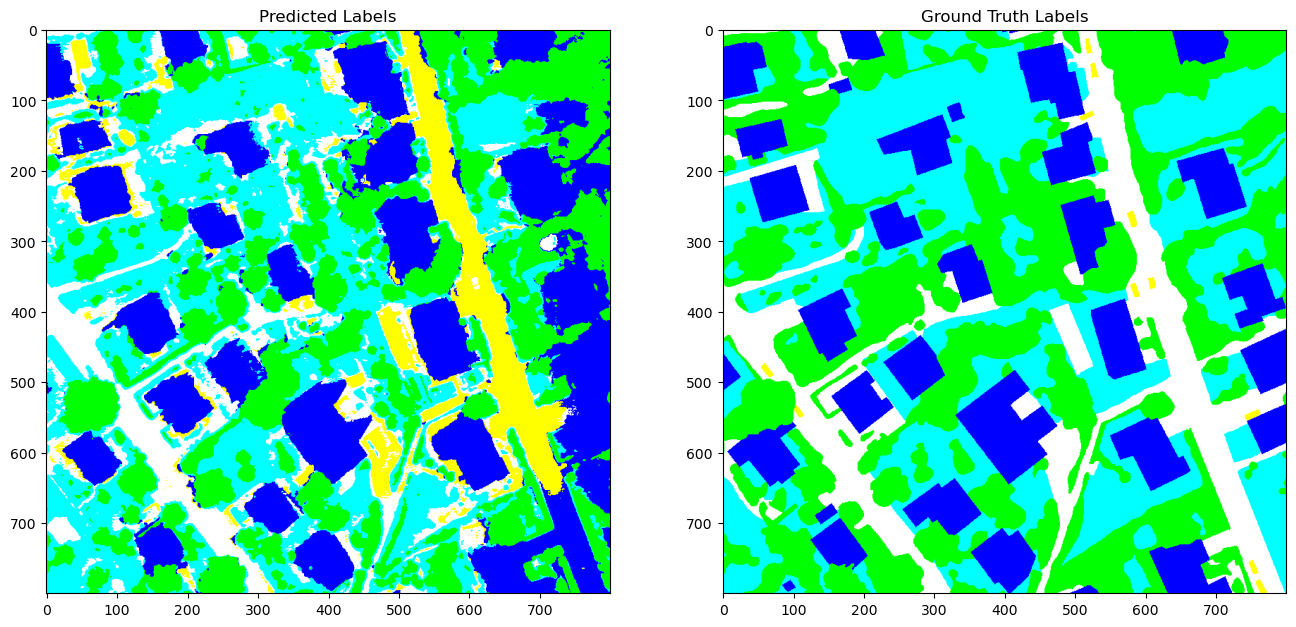

In [14]:
# Make predictions

# Compute likelihoods
L_Y_t = ndc.compute_likelihoods(X_t)  

# Compute posteriors assuming uniform prior
P_Y_t = ndc.compute_posteriors(L_Y_t, [0.20,0.20,0.20,0.20,0.20])
Y_t = np.argmax(P_Y_t, axis=1)

I_pred = get_labels_as_image(Y_t, (800, 800, 3))
I_gt   = get_labels_as_image(y_t, (800, 800, 3))

lab.plot_pred_gt(I_pred, I_gt)

In [15]:
precisions, recalls, f1_scores, overall_accuracy, mean_f1_score = compute_quality_metrics(Y_t, y_t, 5)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('F1-score   [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean F1-score   : {:.2%}'.format(mean_f1_score))

precisions [%]:       [44.449 69.195 59.925 85.417  1.56 ]
recalls    [%]:       [35.439 88.686 55.888 66.367 44.576]
F1-score   [%]:       [39.436 77.737 57.836 74.697  3.014]

overall accuracy: 62.59%
mean F1-score   : 50.54%


#### Training and evaluation of the NDC with multiple features

In the next cell, consider adding more features (NIR, R, G) to the training and test data, then compute the predictions by assuming a uniform prior and run the qualitative and visual evaluation.

precisions [%]:       [71.117 79.534 66.393 75.644  4.513]
recalls    [%]:       [56.925 82.749 56.088 84.902 48.475]
F1-score   [%]:       [63.235 81.109 60.807 80.006  8.258]

overall accuracy: 71.41%
mean F1-score   : 58.68%


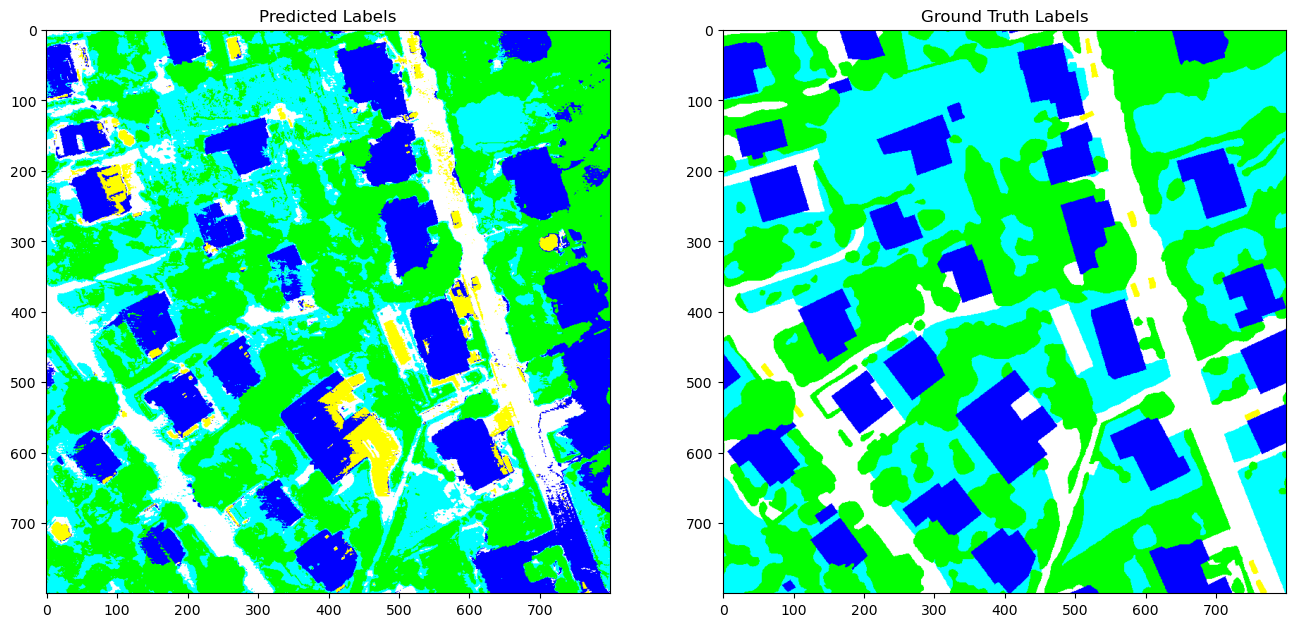

In [16]:
# Load all 5 features (NIR, R, G, NDSM, NDVI)

X_5, y_5 = read_patch(training_set_path)
X_t_5, y_t_5 = read_patch(test_set_path)

# Create classifier instance
ndc_5 = NormalDistributionClassifier(num_classes=num_classes, num_features=5)

# Train the classifier:
ndc_5.fit(X_5, y_5)   

# Make predictions

# Compute likelihoods
L_Y_t_5 = ndc_5.compute_likelihoods(X_t_5)  

# Compute posteriors assuming uniform prior
P_Y_t_5 = ndc_5.compute_posteriors(L_Y_t_5, [0.20,0.20,0.20,0.20,0.20])
Y_t_5   = np.argmax(P_Y_t_5, axis=1)

I_pred  = get_labels_as_image(Y_t_5, (800, 800, 3))
I_gt    = get_labels_as_image(y_t_5, (800, 800, 3))

lab.plot_pred_gt(I_pred, I_gt)

precisions, recalls, f1_scores, overall_accuracy, mean_f1_score = compute_quality_metrics(Y_t_5, y_t_5, 5)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('F1-score   [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean F1-score   : {:.2%}'.format(mean_f1_score))

### Exercise 3.2: Mixture of Gaussian Model

The next cell will fit a Gaussian Mixture Model (GMM) to the samples of each class. The list `N_clusters` defines the number of components per class. __Modify__ the list in a meaningful way by assuming TWO components per class  with a uniform prior.

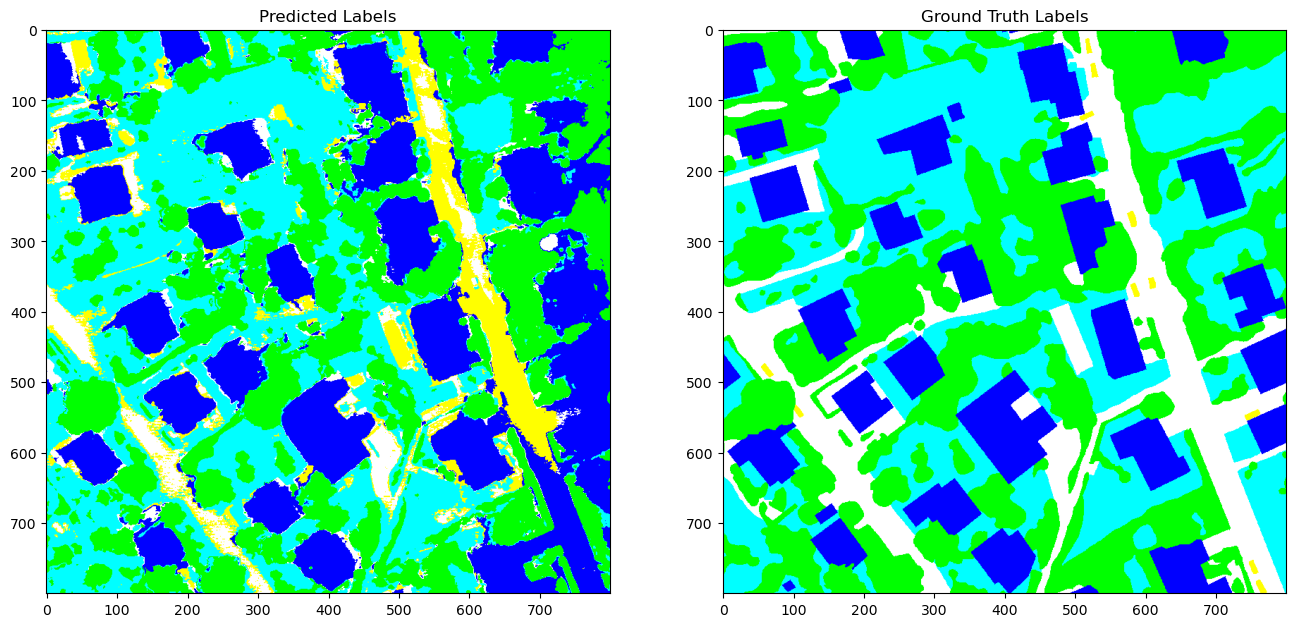

In [17]:
N_clusters = [2,2,2,2,2]  # To be modified!

# Instantiating the classifier
gmm = lab.GaussianMixtureClassifier(N_clusters)

# Train the classifier using EM:
gmm.fit(X, y)   

# Make predictions

# Compute likelihoods
L_Y_t = gmm.compute_likelihoods(X_t)  

# Compute posteriors assuming uniform prior
P_Y_t = gmm.likelihoods_to_posteriors(L_Y_t, [0.20,0.20,0.20,0.20,0.20])
Y_t = np.argmax(P_Y_t, axis=1)

I_pred = get_labels_as_image(Y_t, (800, 800, 3))
I_gt   = get_labels_as_image(y_t, (800, 800, 3))

# Plot predictions
lab.plot_pred_gt(I_pred, I_gt)

__Run__ the next cell for qualitative evaluation:

In [18]:
precisions, recalls, f1_scores, overall_accuracy, mean_f1_score = compute_quality_metrics(Y_t, y_t, 5)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('F1-scores  [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean F1-score   : {:.2%}'.format(mean_f1_score))

precisions [%]:       [56.683 65.631 62.44  82.032  1.553]
recalls    [%]:       [21.47  91.729 61.591 72.553 38.814]
F1-scores  [%]:       [31.144 76.516 62.012 77.002  2.987]

overall accuracy: 64.82%
mean F1-score   : 49.93%


#### Fitting a GMM with multiple features

In the next setup, consider adding more features (NIR, R, G) to the training and test samples, then compute the predictions by assuming a uniform prior and run the qualitative and visual evaluation. You can use the same setting for `N_clusters` as above.

precisions [%]:       [27.252 77.51  52.407 60.632  1.453]
recalls    [%]:       [ 3.632 65.282 40.339 84.271 53.22 ]
F1-score   [%]:       [ 6.41  70.872 45.588 70.523  2.829]

overall accuracy: 54.78%
mean F1-score   : 39.24%


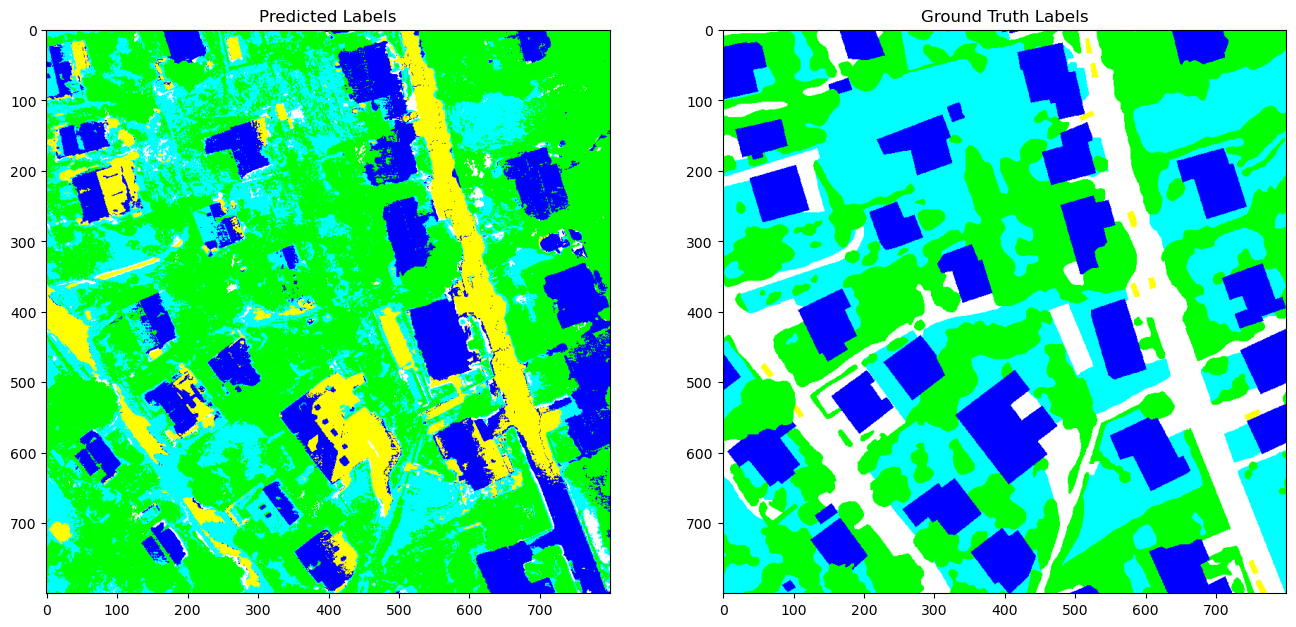

In [19]:
# Load all 5 features (NIR, R, G, NDSM, NDIV)

X_5, y_5 = read_patch(training_set_path)
X_t_5, y_t_5 = read_patch(test_set_path)

# Set similar number of components as in previous setting for each class
N_clusters = [2,2,2,2,2] # To be set! 

# Instantiating the classifier
gmm_5 = lab.GaussianMixtureClassifier(N_clusters)

# Train the classifier using EM:
gmm_5.fit(X_5, y_5)   

# Make predictions

# Compute likelihoods
L_Y_t_5 = gmm_5.compute_likelihoods(X_t_5)  

# Compute posteriors assuming uniform prior
P_Y_t_5 = gmm_5.likelihoods_to_posteriors(L_Y_t_5, [0.20,0.20,0.20,0.20,0.20])
Y_t_5   = np.argmax(P_Y_t_5, axis=1)

I_pred = get_labels_as_image(Y_t_5, (800, 800, 3))
I_gt   = get_labels_as_image(y_t_5, (800, 800, 3))

lab.plot_pred_gt(I_pred, I_gt)

precisions, recalls, f1_scores, overall_accuracy, mean_f1_score = compute_quality_metrics(Y_t_5, y_t_5, 5)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('F1-score   [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean F1-score   : {:.2%}'.format(mean_f1_score))

### Exercise 3.3: Comparison and evaluation


The code in the following cell will compute and print the overall accuracy for both datasets and both models.

In [20]:
_, _, _, oa_ndc_train, mf1_ndc_train = compute_quality_metrics(ndc.predict(X), y, 5)
_, _, _, oa_ndc_test, mf1_ndc_test = compute_quality_metrics(ndc.predict(X_t), y_t, 5)

_, _, _, oa_gmm_train, mf1_gmm_train = compute_quality_metrics(gmm.predict(X), y, 5)
_, _, _, oa_gmm_test, mf1_gmm_test = compute_quality_metrics(gmm.predict(X_t), y_t, 5)

_, _, _, oa_ndc_5_train, mf1_ndc_5_train = compute_quality_metrics(ndc_5.predict(X_5), y_5, 5)
_, _, _, oa_ndc_5_test, mf1_ndc_5_test = compute_quality_metrics(ndc_5.predict(X_t_5), y_t_5, 5)

_, _, _, oa_gmm_5_train, mf1_gmm_5_train = compute_quality_metrics(gmm_5.predict(X_5), y_5, 5)
_, _, _, oa_gmm_5_test, mf1_gmm_5_test = compute_quality_metrics(gmm_5.predict(X_t_5), y_t_5, 5)

print('Overall Accur. | TRAIN-SET| TEST-SET\n' + '-' * 37)
print('SINGLE GAUSSIAN                     |  {:.2%}  |  {:.2%}'.format(oa_ndc_train, oa_ndc_test))
print('SINGLE GAUSSIAN WITH MULT. FEATURES |  {:.2%}  |  {:.2%}'.format(oa_ndc_5_train, oa_ndc_5_test))
print('MIXTURE OF GAU.                     |  {:.2%}  |  {:.2%}'.format(oa_gmm_train, oa_gmm_test))
print('MIXTURE OF GAU. WITH MULT. FEATURES |  {:.2%}  |  {:.2%}'.format(oa_gmm_5_train, oa_gmm_5_test))
print('\n')
print('Mean F1-Score  | TRAIN-SET| TEST-SET\n' + '-' * 37)
print('SINGLE GAUSSIAN                     |  {:.2%}  |  {:.2%}'.format(mf1_ndc_train, mf1_ndc_test))
print('SINGLE GAUSSIAN WITH MULT. FEATURES |  {:.2%}  |  {:.2%}'.format(mf1_ndc_5_train, mf1_ndc_5_test))
print('MIXTURE OF GAU.                     |  {:.2%}  |  {:.2%}'.format(mf1_gmm_train, mf1_gmm_test))
print('MIXTURE OF GAU. WITH MULT. FEATURES |  {:.2%}  |  {:.2%}'.format(mf1_gmm_5_train, mf1_gmm_5_test))

Overall Accur. | TRAIN-SET| TEST-SET
-------------------------------------
SINGLE GAUSSIAN                     |  59.97%  |  62.59%
SINGLE GAUSSIAN WITH MULT. FEATURES |  72.81%  |  71.41%
MIXTURE OF GAU.                     |  69.14%  |  64.82%
MIXTURE OF GAU. WITH MULT. FEATURES |  71.90%  |  54.78%


Mean F1-Score  | TRAIN-SET| TEST-SET
-------------------------------------
SINGLE GAUSSIAN                     |  49.25%  |  50.54%
SINGLE GAUSSIAN WITH MULT. FEATURES |  63.08%  |  58.68%
MIXTURE OF GAU.                     |  59.29%  |  49.93%
MIXTURE OF GAU. WITH MULT. FEATURES |  62.46%  |  39.24%


__Write a discussion__ which __briefly__ answers the following questions: 

- What are the parameters of a single Gaussian model and a Gaussian mixture model?
- How are the parameters determined in the training process for the two models?
- How is an unseen feature vector classified (both models)?
- How would a prior knowledge about the class distribution be taken into account during the class prediction?
- Compare the overall accuracy to the class-specific metrics. Which problem can be observed? Why do you think this problem occurs and what could be done to avoid it?
- Did the classification result improve when using a single Gaussian model (w.r.t. the result of the mixture of Gaussian model)? Why / why not? What can be observed when using multiple features?

#### Discussion

*Write the discussion here. Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

**1.What are the parameters of a single Gaussian model and a Gaussian mixture model?**
 - The parameters of a single Gaussian model are Mean value and Covariance matrix. The parameters of a Gaussian mixture model are Mixture coefficient, Mean value and Covariance matrix.

**2.How are the parameters determined in the training process for the two models?**
 - Single Gaussian Model: The Mean value and Covariance matrix of the Gaussian distribution are estimated directly from the training data using maximum likelihood estimation (MLE).The Mean value is calculated as:μ = (1/N) * Σx, where μ is the estimated mean vector, N is the number of observations, and Σx represents the sum of all the observed vectors.The Covariance matrix is calculated as:Σ = (1/N) * Σ((x - μ)(x - μ)ᵀ),where Σ is the estimated covariance matrix, N is the number of observations, x represents an observed vector, μ is the estimated mean vector, and (x - μ)(x - μ)ᵀ denotes the outer product of the difference between an observed vector and the estimated mean vector. By using MLE, the mean value and covariance matrix are estimated directly from the training data.
 - Gaussian Mixture Model: The parameters of Gaussian Mixture Model are determined using K-Means Clustering algorithm or Expectation-Maximization (EM) algorithm. The Process of K-Means Clustering: First we should initialize N cluster centres μ. Then we determine the Euclidean distance between x and μ and assign x to cluster j with minimum distance d. After that we should determine new cluster centres μ as means over all points x assigned to cluster j. Finally we should repeat until a stable situation or a maximum number of iterations is achieved.

**3.How is an unseen feature vector classified (both models)?**
 - Single Gaussian Model: We can compute the probability density of the feature vector under the Gaussian distribution. Then we assign it to the class with the highest probability.
 - Gaussian Mixture Model: We can calculate the probability density of the feature vector under that component. Then, we weight these probabilities by the component weights and assign the feature vector to the class with the highest overall probability.

**4.How would a prior knowledge about the class distribution be taken into account during the class prediction?**
 - Prior knowledge about the class distribution can be incorporated by assigning prior probabilities to each class. During class prediction, these prior are combined with the Likelihood to obtain the posterior using Bayes' theorem.

**5.Compare the overall accuracy to the class-specific metrics. Which problem can be observed? Why do you think this problem occurs and what could be done to avoid it?**
 - About the class-specific metrics We can see that the model's performance is not consistent across all classes.For example, the recognition of buildings is very good but the recognition of cars is very poor.This is why theoverall accuracy is not so good about 60%. 
 - The reason may be that the model performs terrible on car and the training data is too little.We schould analyze the features used by the model and consider whether additional relevant features can be included or if any existing features can be further refined to improve the model's ability to distinguish between different classes.

**6.Did the classification result improve when using a single Gaussian model (w.r.t. the result of the mixture of Gaussian model)? Why / why not? What can be observed when using multiple features?**
 - The classification result improve a little when using a single Gaussian model (w.r.t. the result of the mixture of Gaussian model).
 - This is because a mixture of Gaussian model allows for more complex representations of the data by combining multiple Gaussian distributions. The complexity of the data and the underlying distribution can affect the performance of the models.
 - When multiple features are used, we can observe that using multiple features improves the classification results for the single Gaussian model, but the classification results for the Gaussian mixture model get bad.


## Exercise 4: Application to a synthetic toy dataset

### Exercise 4.1: Drawing samples 
Use the given function `lab.generate_gaussian_clusters()` to create synthetic data samples in a 2D feature space. The dataset should be drawn from 5 Gaussians, each corresponding to a cluster. There are 4 classes; three classes correspond to one cluster only, whereas one class (class 2) corresponds to two clusters. The clusters are defined in the following table:

| Cluster | Center x | Center y | Variance x | Variance y | Angle | Samples | Class |
|-|-|-|-|-|-|-|-|
| __1__ | 55 | 190| 20| 10|  45| 550| 0 |
| __2__ | 170|  90| 45| 25| 135| 500| 1 |
| __3__ | 200| 200| 30| 15| 120| 300| 2 |
| __4__ | 60 |  60| 25| 20|  60| 250| 2 |
| __5__ | 220|  10| 10| 20|  0 | 450| 3 |

__Modify__ the variable `clusters` according to the table. Read the documentation of the function in __lab.py__ to get further information about the arguments and the return values.

In [21]:
clusters = [
    (0,  55, 190, 20, 10,  45, 550),
    (1, 170,  90, 45, 25, 135, 500),
    (2, 200, 200, 30, 15, 120, 300),
    (2,  60,  60, 25, 20,  60, 250),
    (3, 220,  10, 10, 20,   0, 450)
] # To be modified!

#  clusters : list of tuples
#             Each cluster is defined by 7 parameters:
#             [(class, c_x, c_y, varx, vary, angle (degree), num_samples), ...]
samples = lab.generate_gaussian_clusters(clusters)
print('Number of generated samples N =', samples.shape[0])

Number of generated samples N = 2050


### Exercise 4.2: Splitting the data into a training set and a test set 

__Implement__ the function below, which takes the $N$ `samples` as well as the the ratio $r_{test} = N_{test}/N$ of training samples and returns:

- $X$: training set features as array with shape $(N_{train}\times 2)$
- $y$: training set labels as array with shape $(N_{train})$ 
- $X_t$: test set features as array with shape $(N_{test}\times 2)$
- $y_t$: test set labels as array with shape$ (N_{test})$

where $N_{train} = N\cdot(1-r_{test})$ is the number of training samples and $N_{test} = N\cdot r_{test}$ is the number of samples for testing. Make sure to __shuffle__ the samples randomly (e.g. using `np.random.shuffle()`)!

In [22]:
def split_train_test(samples, r_test):
    

    # YOUR CODE GOES HERE
    np.random.shuffle(samples)

    N_test  = int(samples.shape[0] * r_test)
    
    # N_train = samples.shape() * (1 - r_test)

    Test  = samples[:N_test]
    Train = samples[N_test :]

    X   = Test[:,:2]   # training set features
    y   = Test[:, 2]   # training set labels

    X_t = Train[:,:2]    # test set features
    y_t = Train[:, 2]    # test set labels
    
    return X, y, X_t, y_t

__Run__ the next cell. It will use your function to generate and visualize the sets for training and testing.

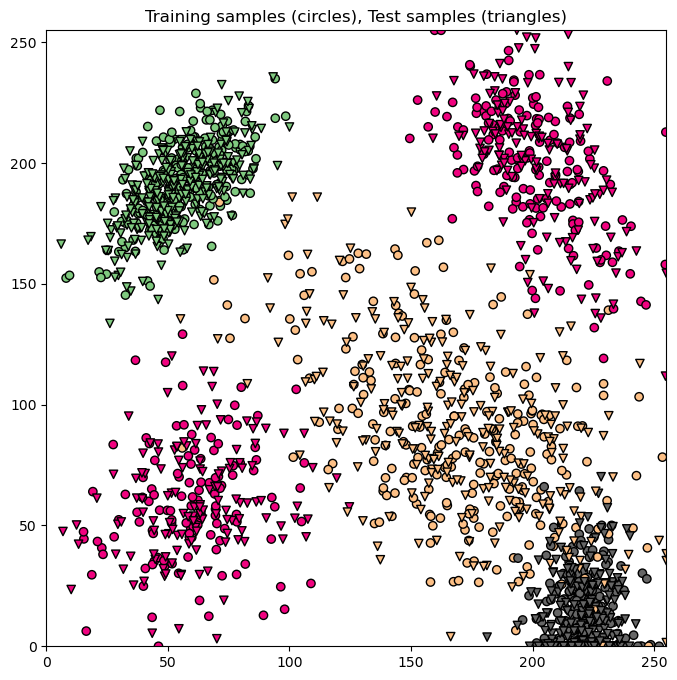

In [23]:
X, y, X_t, y_t = split_train_test(samples, 0.5)

# Plot both sets:
matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize]  
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=CMAP)
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, edgecolors='k', cmap=CMAP, marker='v')
plt.xlim((0, 255)); plt.ylim((0, 255))
plt.title('Training samples (circles), Test samples (triangles)')
plt.show()

__Run__ the next cell to fit a single Gaussian model to the training data.

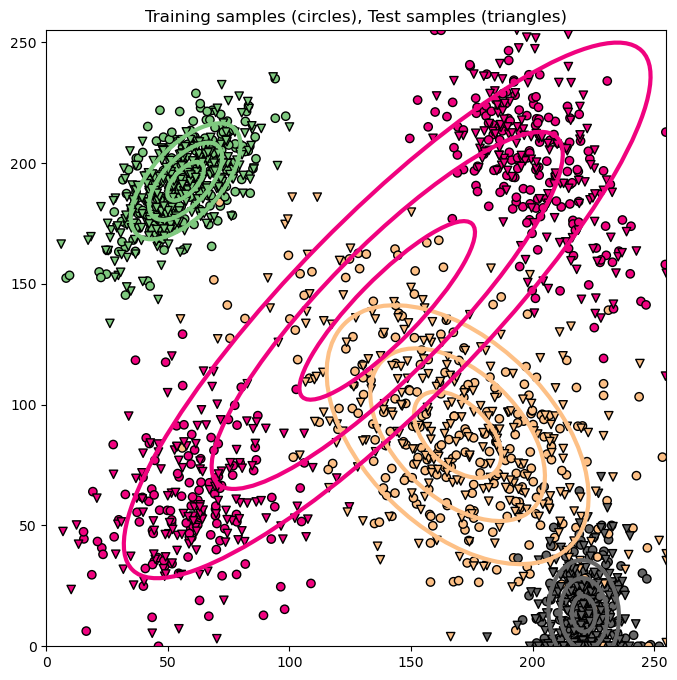

In [24]:
# Create classifier instance
ndc = NormalDistributionClassifier(num_classes=4, num_features=2)

# Train the classifier
ndc.fit(X, y)

# Plot datasets
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=CMAP)
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, edgecolors='k', cmap=CMAP, marker='v')

# Plot confidence ellipses: 0.5 sigma, 1 sigma, 1.5 sigma
lab.plot_sigma_ellipses(ndc, CMAP, sigmas = [0.5, 1, 1.5])

plt.xlim((0, 255)); plt.ylim((0, 255))
plt.title('Training samples (circles), Test samples (triangles)')
plt.show()

Next, the likelihoods for each class can be visualized by computing the likelihood for each feature vector on a $255 \times 255$ grid.

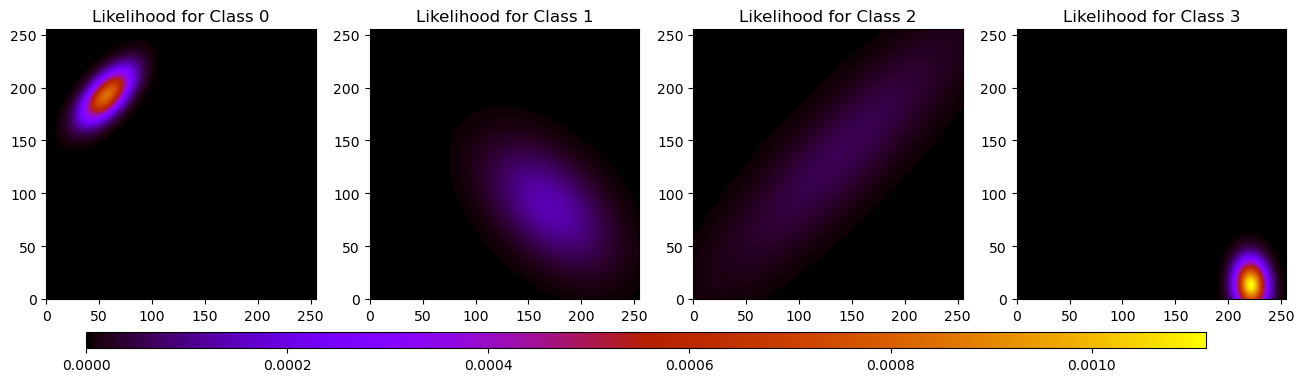

In [25]:
# Create a meshgrid set of 'all' features in the limits
xx, yy = np.meshgrid(np.arange(0, 256, 1), np.arange(0, 256, 1))
mesh_features = np.c_[xx.ravel(), yy.ravel()]

# Get likelihoods for the meshgrid samples
L = ndc.compute_likelihoods(mesh_features)
lab.print_probabilities(L, (256, 256), 'Likelihood', n_cls=4)

Another way of visually analyzing a classifier is to plot the decision boundaries. In the next cell the whole feature space will be classified according to ML classification, which implicitly shows the decision boundaries.

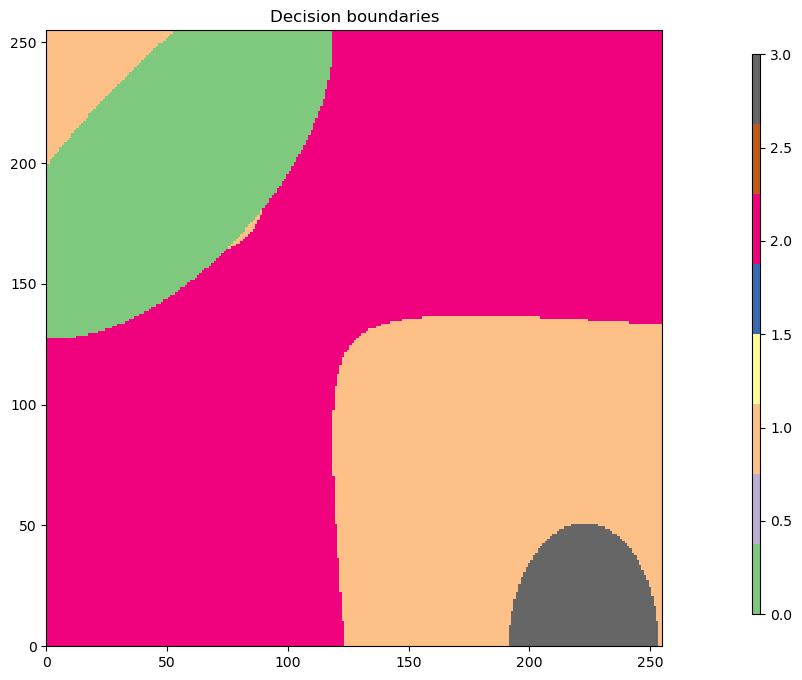

In [26]:
C = ndc.predict(mesh_features)
lab.print_decision_boundaries(C, (256, 256))

#### Considering prior information

In the next example, assume that the prior probability for class 2 is 75 times higher than for the other classes. __Note__ that $P_{prior}$ must sum up to 1 to be a valid distribution. Run the cell and make a sanity-check of the results.

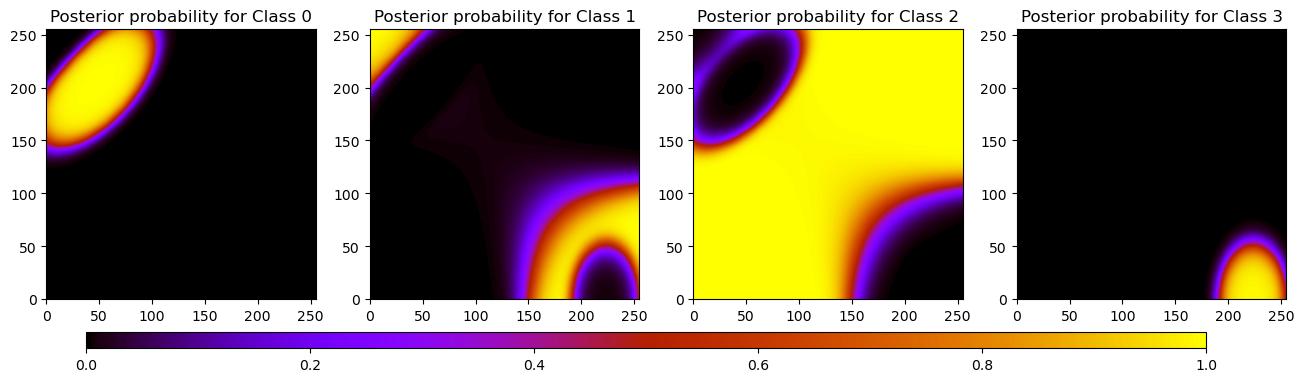

In [27]:
P_prior = P_prior = [1/78, 1/78 ,75/78, 1/78] # Assume that class 2 is 75 times more probable. To be modified! (The distribution should sum up to 1)

# Get posteriors for the new test samples
P_post = ndc.compute_posteriors(L, P_prior)
lab.print_probabilities(P_post, (256, 256), 'Posterior probability', n_cls=4)

### Exercise 4.3: Mixture of Gaussian Model

__Run__ the next cell trains a Gaussian Mixture Model to the training set of the toy dataset of each class. The list `N_clusters` defines the number of components per class. 

__Modify__ this list in a meaningful way.

C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


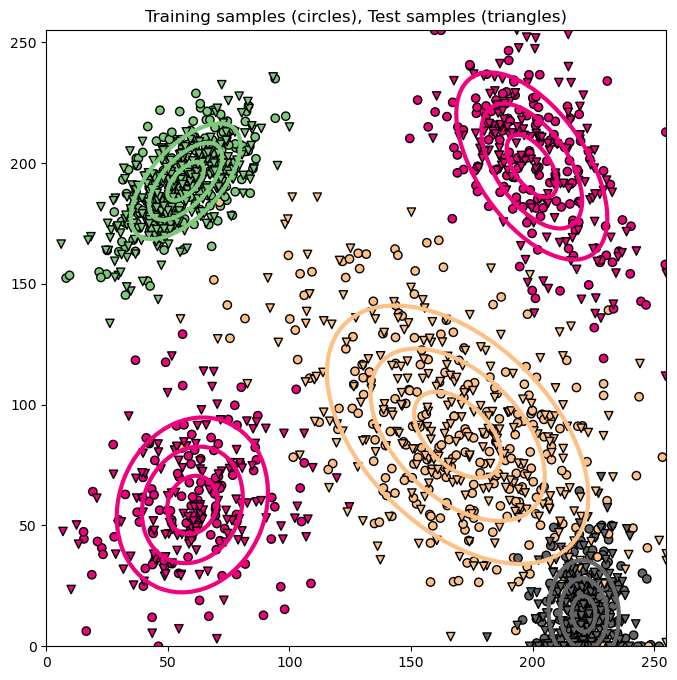

In [35]:
N_clusters = [1,1,2,1] # To be modified! 
#N_clusters = [1,1,1,1] # To be modified! 
# Instantiating the classifier
gmm = lab.GaussianMixtureClassifier(N_clusters)

# Train the classifier using EM:
gmm.fit(X, y)   

# Plot datasets
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=CMAP)
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, edgecolors='k', cmap=CMAP, marker='v')

# Plot confidence ellipses: 0.5 sigma, 1 sigma, 1.5 sigma
gmm.plot_sigma_ellipses(CMAP, sigmas = [0.5, 1, 1.5]) 

plt.xlim((0, 255)); plt.ylim((0, 255)); 
plt.title('Training samples (circles), Test samples (triangles)')
plt.show()

The next two cells will again compute and show the likelihood for the complete feature space and plot the decision boundaries.

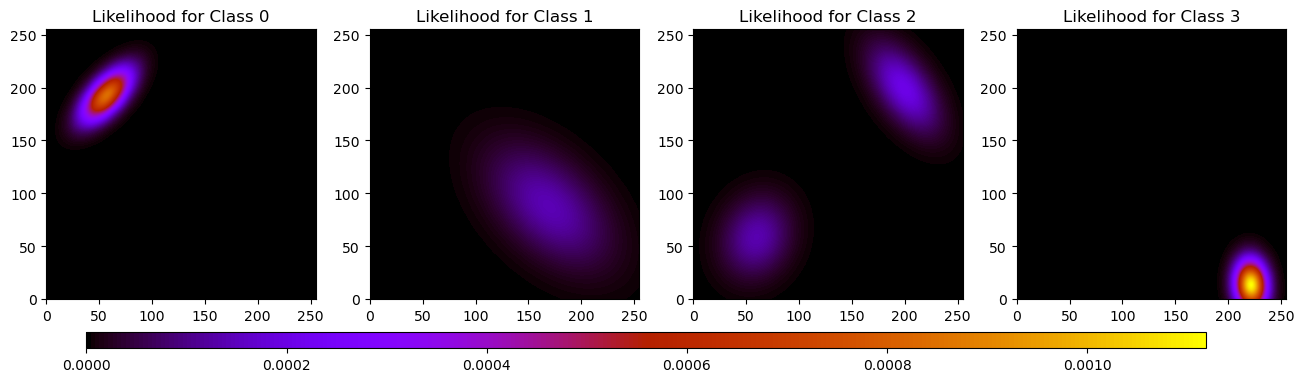

In [36]:
# Get likelihoods for the meshgrid samples
L = gmm.compute_likelihoods(mesh_features)
lab.print_probabilities(L, (256, 256), 'Likelihood', n_cls=4)

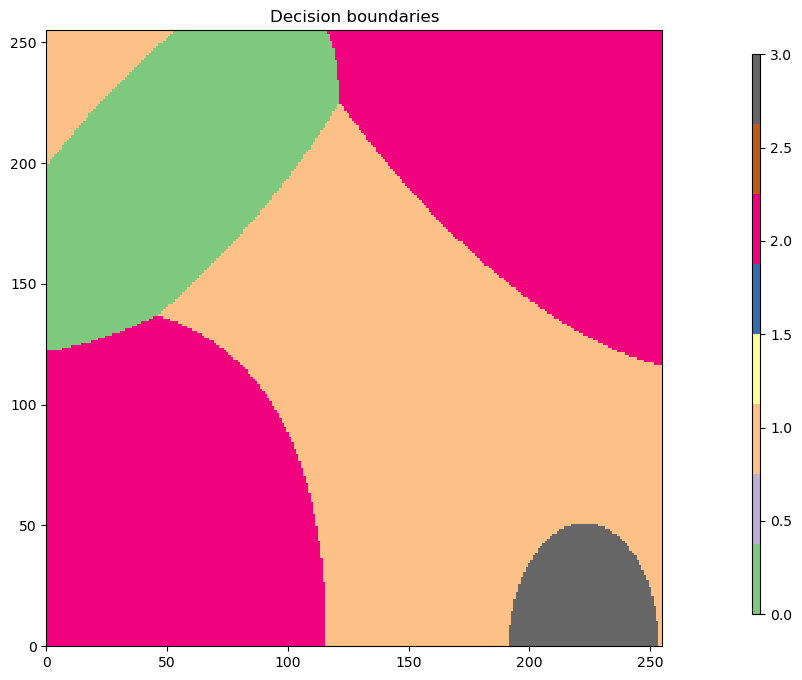

In [37]:
C = gmm.predict(mesh_features) # this will assume a uniform prior
lab.print_decision_boundaries(C, (256, 256))

### Exercise 4.4: Comparison and evaluation

__Print__ the likelihood, the posterior and the predicted class for the feature vector $X_{150} = (150, 150)$ using the NDC and GMM (assuming a uniform prior).

In [38]:
# YOUR CODE GOES HERE!
x_150 = np.array([150,150]).reshape(1,-1)

L_150 = ndc.compute_likelihoods(x_150)
print("Likelihood of ndc is: ", L_150)
L_post= ndc.compute_posteriors(L_150, [0.25,0.25,0.25,0.25])
print("Posteriors of ndc is: ", L_post)
L_C = ndc.predict(x_150)
print("Predict of ndc is: ", L_C)


LL_150 = gmm.compute_likelihoods(x_150)
print("Likelihood of gmm is: ", LL_150)
LL_post = gmm.likelihoods_to_posteriors(LL_150, [0.25,0.25,0.25,0.25])
print("Posteriors of gmm is: ", LL_post)
LL_C = gmm.predict(x_150)
print("Predict of gmm is: ", LL_C)

Likelihood of ndc is:  [[6.755e-27 2.895e-05 6.068e-05 2.406e-32]]
Posteriors of ndc is:  [[7.537e-23 3.230e-01 6.770e-01 2.685e-28]]
Predict of ndc is:  [2]
Likelihood of gmm is:  [[5.556e-27 2.888e-05 6.351e-09 1.820e-32]]
Posteriors of gmm is:  [[1.923e-22 9.998e-01 2.199e-04 6.302e-28]]
Predict of gmm is:  [1]


__Write__ a brief discussion, which answers the following questions:

- Based on the prediction of the feature $X_{150}$, discuss the model performance. Which model achieves better results and why? 
- What happens when the number of components of a GMM is chosen to high / to low? Try and document different variants with respect to the number of clusters.

#### Discussion

*Write the discussion here. Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

### Answer
- **Based on the prediction of the feature $X_{150}$, discuss the model performance. Which model achieves better results and why?**
  - A comparison of the outputs shows that both models predict the outcome for class 2. However, using the ndc model, the posterior result for class 2 is: `6.918e-01`. Using the gmm model, the posterior result for class 2 is:`6.931e-01`. After comparison the gmm model has a higher prediction result.  
  - The reason is that although both models are based on probabilities, to calculate the classification of the results. Unlike the ndc model, gmm assumes that the features are composed of multiple Gaussian distributions, each of which represents a cluster, and by calculating the probability of each data point on each Gaussian distribution, the cluster to which it belongs can be determined. This has better results for the case where the boundaries are not obvious in the feature space.
   

- **What happens when the number of components of a GMM is chosen to high / to low? Try and document different variants with respect to the number of clusters.**
    - In the cell below, the number of clusters for the `gmm_150` model is changed by changing the number of `N_clusters`. A comparison of the output shows that the model predicts class 1 from the second loop onwards. In addition as the number grows, the prediction for class 1 becomes higher to 1.

In [39]:
x_150 = np.array([150,150]).reshape(1,-1)

for i in range(6):
    i = i+1

    N_clusters = [i,i,i,i]
    # print(N_clusters)

    # Instantiating the classifier
    gmm_150 = lab.GaussianMixtureClassifier(N_clusters)

    # Train the classifier using EM:
    gmm_150.fit(X, y) 

    LL_150 = gmm_150.compute_likelihoods(x_150)
    # print("Likelihood of gmm is: ", LL_150)
    LL_post = gmm_150.likelihoods_to_posteriors(LL_150,[0.25,0.25,0.25,0.25])
    print("Posteriors of gmm is: ", LL_post)
    LL_C = gmm_150.predict(x_150)
    print("Predict of gmm is: ", LL_C)  
    print("\n")

C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Tynda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Window

Posteriors of gmm is:  [[6.189e-23 3.217e-01 6.783e-01 2.028e-28]]
Predict of gmm is:  [2]


Posteriors of gmm is:  [[2.318e-18 9.998e-01 2.292e-04 3.831e-29]]
Predict of gmm is:  [1]


Posteriors of gmm is:  [[1.644e-18 9.998e-01 2.053e-04 1.608e-31]]
Predict of gmm is:  [1]


Posteriors of gmm is:  [[1.376e-20 9.999e-01 9.584e-05 7.022e-27]]
Predict of gmm is:  [1]


Posteriors of gmm is:  [[9.933e-24 9.996e-01 4.200e-04 1.152e-25]]
Predict of gmm is:  [1]


Posteriors of gmm is:  [[7.625e-21 9.996e-01 3.713e-04 7.438e-26]]
Predict of gmm is:  [1]




**That's all we've done. We hope you enjoy reading it.   (Gruppe 3)**